# Importing Libraries

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import holidays
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge, Lasso
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb
import shap
import warnings
warnings.filterwarnings("ignore")

# Load & Preprocess the dataset

In [33]:
df = pd.read_csv('Uber-Jan-Feb-FOIL.csv')
df.head()

,dispatching_base_number,date,active_vehicles,trips
0,B02512,1/1/2015,190,1132
1,B02765,1/1/2015,225,1765
2,B02764,1/1/2015,3427,29421
3,B02682,1/1/2015,945,7679
4,B02617,1/1/2015,1228,9537


In [34]:
df.columns
print(df.columns.tolist())


['dispatching_base_number', 'date', 'active_vehicles', 'trips']


In [35]:
df['date'] = pd.to_datetime(df['date'])
df = df.groupby('date').size().reset_index(name='Trip_Count')
df = df.sort_values('date')


In [52]:
print(df.columns.tolist())

['date', 'Trip_Count', 'Rolling_Mean_3', 'Lag_1', 'Lag_2']


In [55]:
df['DayOfWeek'] = df['date'].dt.dayofweek
df['Is_Weekend'] = df['DayOfWeek'].isin([5, 6]).astype(int)
df['WeekOfYear'] = df['date'].dt.isocalendar().week
df['Is_MonthStart'] = df['date'].dt.is_month_start.astype(int)

us_holidays = holidays.US(years=[2015])
df['Is_Holiday'] = df['date'].isin(us_holidays).astype(int)

# EDA

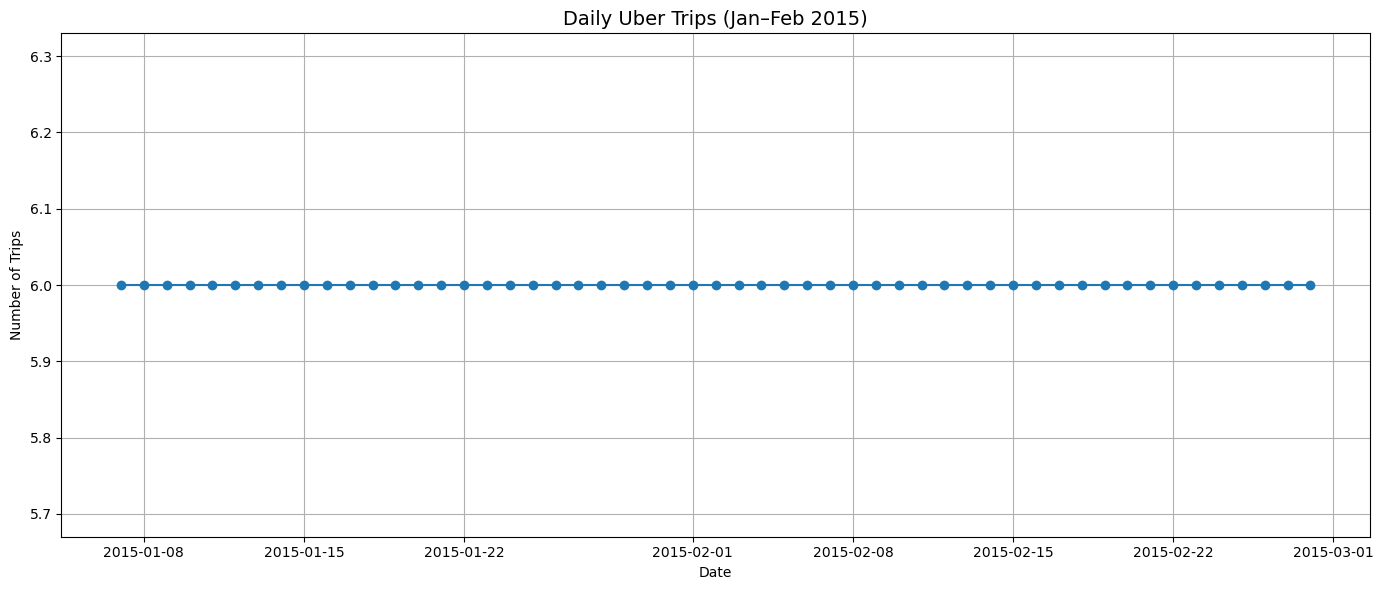

In [56]:
plt.figure(figsize=(14, 6))
plt.plot(df['date'], df['Trip_Count'], marker='o', linestyle='-')
plt.title('Daily Uber Trips (Jan–Feb 2015)', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Number of Trips')
plt.grid(True)
plt.tight_layout()
plt.show()


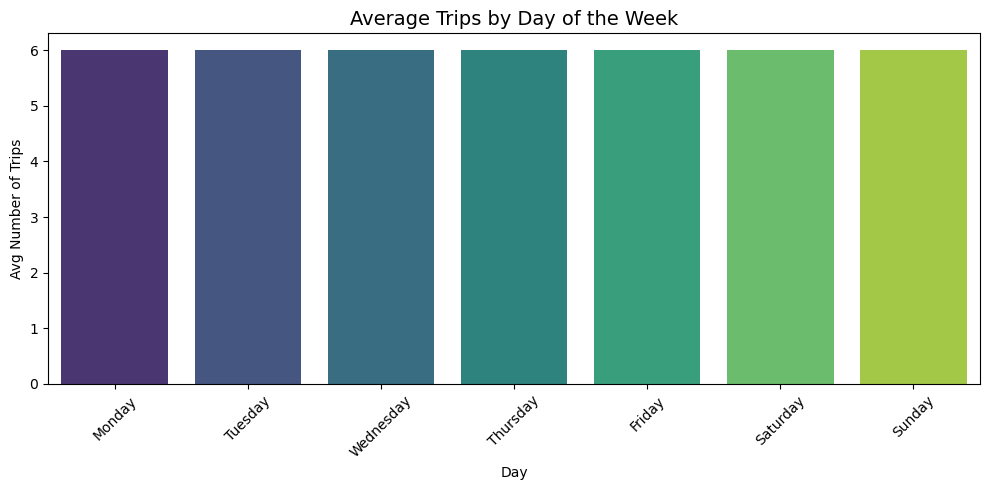

In [57]:
df['DayOfWeek'] = df['date'].dt.day_name()
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

plt.figure(figsize=(10, 5))
sns.barplot(data=df, x='DayOfWeek', y='Trip_Count', order=day_order, palette='viridis')
plt.title('Average Trips by Day of the Week', fontsize=14)
plt.xlabel('Day')
plt.ylabel('Avg Number of Trips')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


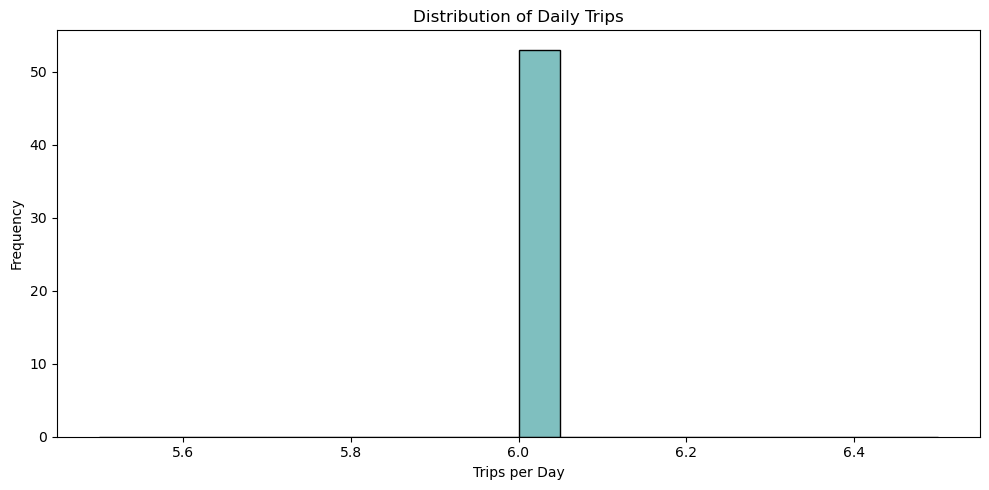

In [58]:
plt.figure(figsize=(10, 5))
sns.histplot(df['Trip_Count'], bins=20, kde=True, color='teal')
plt.title('Distribution of Daily Trips')
plt.xlabel('Trips per Day')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()


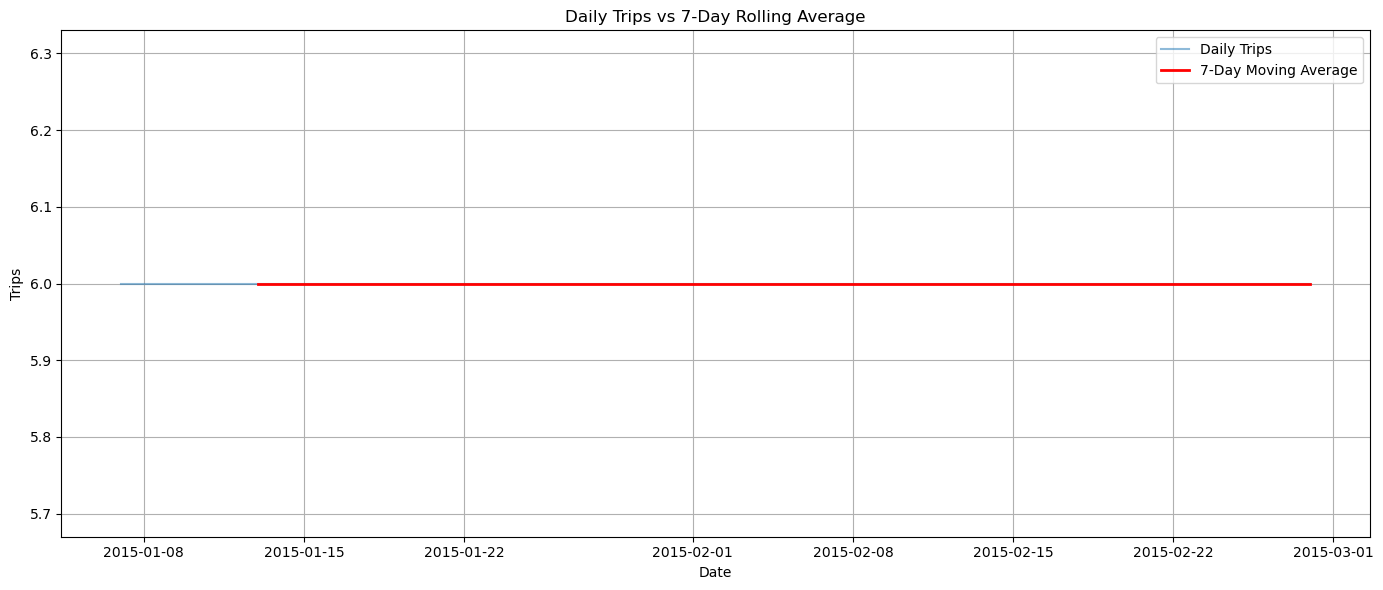

In [59]:
df['7_day_avg'] = df['Trip_Count'].rolling(window=7).mean()

plt.figure(figsize=(14, 6))
plt.plot(df['date'], df['Trip_Count'], label='Daily Trips', alpha=0.5)
plt.plot(df['date'], df['7_day_avg'], label='7-Day Moving Average', color='red', linewidth=2)
plt.title('Daily Trips vs 7-Day Rolling Average')
plt.xlabel('Date')
plt.ylabel('Trips')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


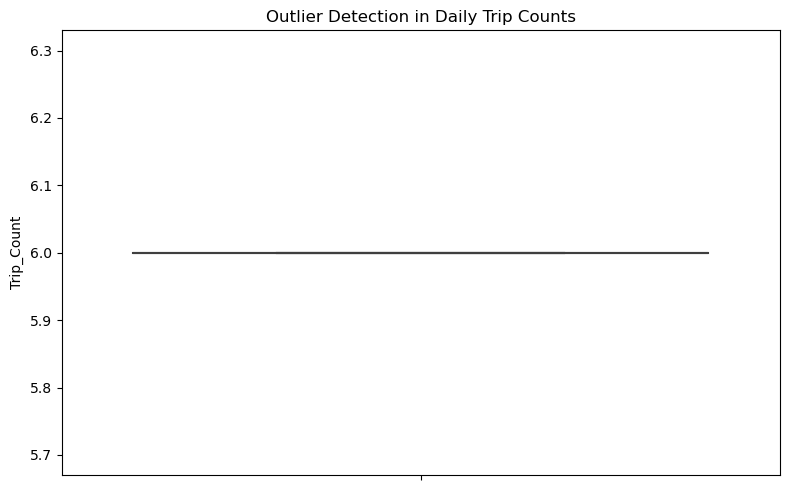

In [60]:
plt.figure(figsize=(8, 5))
sns.boxplot(data=df, y='Trip_Count')
plt.title('Outlier Detection in Daily Trip Counts')
plt.tight_layout()
plt.show()


# Feature Engineering 

In [61]:
df['Rolling_Mean_3'] = df['Trip_Count'].rolling(window=3).mean()
df['Lag_1'] = df['Trip_Count'].shift(1)
df['Lag_2'] = df['Trip_Count'].shift(2)

# Drop initial NaN rows
df.dropna(inplace=True)

df.head()


,date,Trip_Count,Rolling_Mean_3,Lag_1,Lag_2,DayOfWeek,Is_Weekend,WeekOfYear,Is_MonthStart,Is_Holiday,7_day_avg
12,2015-01-13,6,6.0,6.0,6.0,Tuesday,0,3,0,0,6.0
13,2015-01-14,6,6.0,6.0,6.0,Wednesday,0,3,0,0,6.0
14,2015-01-15,6,6.0,6.0,6.0,Thursday,0,3,0,0,6.0
15,2015-01-16,6,6.0,6.0,6.0,Friday,0,3,0,0,6.0
16,2015-01-17,6,6.0,6.0,6.0,Saturday,1,3,0,0,6.0


# Train-Test-Split

In [67]:
df['DayOfWeek'] = df['date'].dt.dayofweek  # 0–6 as integers


In [68]:
features = ['DayOfWeek', 'Is_Weekend', 'WeekOfYear', 'Is_MonthStart', 'Is_Holiday', 
            'Rolling_Mean_3', 'Lag_1', 'Lag_2']

df = df.sort_values('date')

# Select the split point (e.g., last 20% for testing)
split_index = int(len(df) * 0.8)

train = df.iloc[:split_index]
test = df.iloc[split_index:]

X_train = train[features]
y_train = train['Trip_Count']

X_test = test[features]
y_test = test['Trip_Count']


# Model Development

In [71]:
# Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
rf_preds = rf.predict(X_test)

In [72]:
# XGBoost
xg = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
xg.fit(X_train, y_train)
xg_preds = xg.predict(X_test)

# Evaluation

In [73]:
def evaluate_model(name, y_true, y_pred):
    print(f"{name}")
    print(f"MAE : {mean_absolute_error(y_true, y_pred):.2f}")
    print(f"RMSE: {mean_squared_error(y_true, y_pred, squared=False):.2f}")
    print(f"R²  : {r2_score(y_true, y_pred):.2f}\n")

evaluate_model("Random Forest", y_test, rf_preds)
evaluate_model("XGBoost", y_test, xg_preds)


Random Forest
MAE : 0.00
RMSE: 0.00
R²  : 1.00

XGBoost
MAE : 0.00
RMSE: 0.00
R²  : 1.00



# Visualizing the predictions

In [75]:
print(len(test_df['date']))
print(len(y_test))
print(len(rf_preds))


13
10
10


In [76]:
test_df = test.iloc[-len(y_test):]


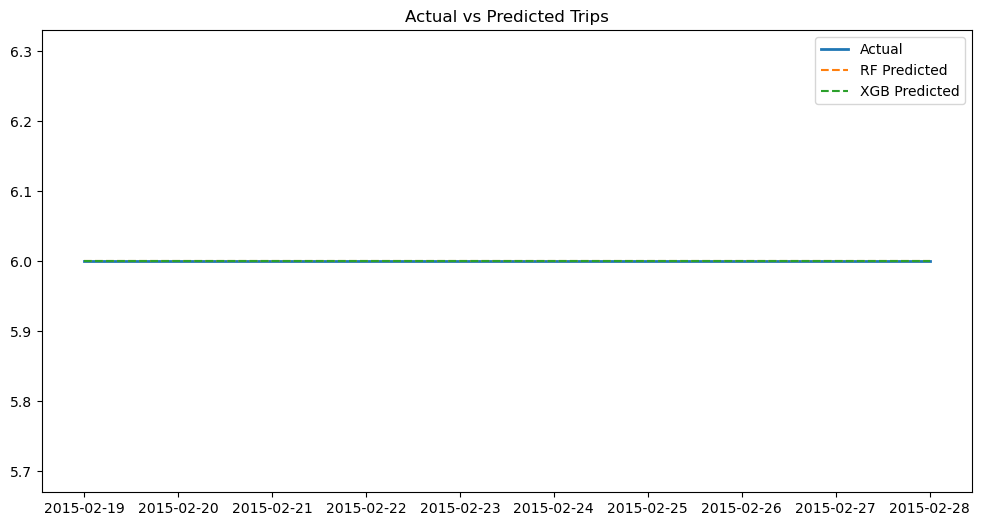

In [77]:
plt.figure(figsize=(12, 6))
plt.plot(test_df['date'], y_test, label='Actual', linewidth=2)
plt.plot(test_df['date'], rf_preds, label='RF Predicted', linestyle='--')
plt.plot(test_df['date'], xg_preds, label='XGB Predicted', linestyle='--')
plt.legend()
plt.title("Actual vs Predicted Trips")
plt.show()


# Model Interpretability

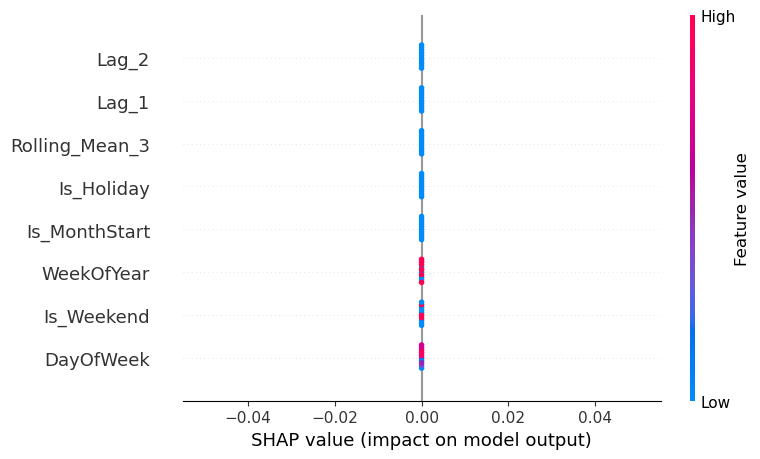

In [79]:
explainer = shap.Explainer(xg)
shap_values = explainer(X_test)
shap.summary_plot(shap_values, X_test)
